# Import Modules

In [1]:
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics import F1Score
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters Config

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=65,
        input_size_left_context=64,
        input_size_oov_context=20,
        input_size_right_context=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        output_size=3611,
        shuffle=True,
        lr=0.001,
        batch_first=True,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=20,
        patience=20,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device
        
hyperparams = Hyperparams()

# Prepare Feature Dataset

In [3]:
def convert_doc_to_idxs(docs, dict_vocabs):
    doc_to_idx = []
    
    for doc in docs:
        doc_to_idx.append([dict_vocabs[token] for token in doc])
        
    return np.array(doc_to_idx)

# Left context
left_context = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_with_pad.pkl", "rb")
left_context = pickle.load(left_context)
left_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_left_context.pkl", "rb")
left_context_to_idx = pickle.load(left_context_to_idx)
doc_left_context_to_idx = convert_doc_to_idxs(left_context, left_context_to_idx)

# OOV context
oov_context = open(f"../../datasets/features/{hyperparams.context_size}_context/oov_context_with_pad.pkl", "rb")
oov_context = pickle.load(oov_context)
oov_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_oov_context.pkl", "rb")
oov_context_to_idx = pickle.load(oov_context_to_idx)
doc_oov_context_to_idx = convert_doc_to_idxs(oov_context, oov_context_to_idx)

# Right context
right_context = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_with_pad.pkl", "rb")
right_context = pickle.load(right_context)
right_context_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/token2idx_right_context.pkl", "rb")
right_context_to_idx = pickle.load(right_context_to_idx)
doc_right_context_to_idx = convert_doc_to_idxs(right_context, right_context_to_idx)

# Actual labels
labels_context = open(f"../../datasets/features/{hyperparams.context_size}_context/lables.pkl", "rb")
labels_context = pickle.load(labels_context)
labels_to_idx = open(f"../../datasets/features/{hyperparams.context_size}_context/lable_vocabs.pkl", "rb")
labels_to_idx = pickle.load(labels_to_idx)
doc_labels_to_idx = convert_doc_to_idxs(labels_context, labels_to_idx).flatten()

print(f"Left context shape: {doc_left_context_to_idx.shape}")
print(f"OOV context shape: {doc_oov_context_to_idx.shape}")
print(f"Right context shape: {doc_right_context_to_idx.shape}")
print(f"Actual lable shape: {doc_labels_to_idx.shape}")

Left context shape: (16562, 62)
OOV context shape: (16562, 28)
Right context shape: (16562, 63)
Actual lable shape: (16562,)


In [4]:
# Convert to Tensor
left_contexts = torch.LongTensor(doc_left_context_to_idx)
oov_contexts = torch.LongTensor(doc_oov_context_to_idx)
right_contexts = torch.LongTensor(doc_right_context_to_idx)
actual_labels = torch.LongTensor(doc_labels_to_idx)
dataset = TensorDataset(left_contexts, oov_contexts, right_contexts, actual_labels)

# Char and Word Embedding

In [5]:
# Word Embedding
word_embeddings = Embedding.load("../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
word_embeddings.apply_expansion(DigitExpander)
word_embeddings.apply_expansion(CaseExpander)

left_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/left_context_vocabs.pkl", "rb")
left_vocabs = pickle.load(left_vocabs)

right_vocabs = open(f"../../datasets/features/{hyperparams.context_size}_context/right_context_vocabs.pkl", "rb")
right_vocabs = pickle.load(right_vocabs)

left_word_embedding_dict = {left_context_to_idx[vocab] : word_embeddings[vocab] for vocab in left_vocabs}
right_word_embedding_dict = {right_context_to_idx[vocab] : word_embeddings[vocab] for vocab in right_vocabs}

# Char Embedding
char_embedding_dict = open("../../word_embeddings/chars_embedding/char_embeddings.pkl", "rb")
char_embedding_dict = pickle.load(char_embedding_dict)

# Context embedding
left_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(left_word_embedding_dict.values()))), padding_idx=left_vocabs.index("<PAD>"), freeze=True)
oov_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(char_embedding_dict.values()))), padding_idx=list(char_embedding_dict.keys()).index("PAD"), freeze=True)
right_context_embedding = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(right_word_embedding_dict.values()))), padding_idx=right_vocabs.index("<PAD>"), freeze=True)

# Dataloader

In [6]:
dataloader = DataLoader(dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

# Model

In [7]:
class Comick(nn.Module):
    def __init__(
        self,
        input_size_left_context=hyperparams.input_size_left_context,
        input_size_oov_context=hyperparams.input_size_oov_context,
        input_size_right_context=hyperparams.input_size_right_context,
        hidden_size=hyperparams.hidden_size,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(Comick, self).__init__()
        
        self.input_size_left_context = input_size_left_context
        self.input_size_oov_context = input_size_oov_context
        self.input_size_right_context = input_size_right_context
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        
        self.bilstm_left_context_feature = nn.LSTM(
            input_size = self.input_size_left_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_oov_context_feature = nn.LSTM(
            input_size = self.input_size_oov_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.bilstm_right_context_feature = nn.LSTM(
            input_size = self.input_size_right_context,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2 * self.hidden_size, 64),
            nn.Tanh()
        )
        
        self.oov_embedding = nn.Linear(in_features=3 * 64, out_features=64)
        
        self.embedding = np.empty((output_size, 64), dtype=np.float32)
        
        self.prob = nn.Sequential(
            nn.Linear(64, self.output_size),
            nn.LogSoftmax(dim=1)
        )
                
        if init_wb_with_kaiming_normal:
            self.init_wb()
            
    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))

    def forward(
        self,
        input_left_context,
        input_oov_context,
        input_right_context,
        idxs_target,
        hidden_left_context=None,
        hidden_oov_context=None,
        hidden_right_context=None,
    ):
        # BiLSTM left, oov, and right context
        output_left_context, (hidden_left_context, memory_left_context) = self.bilstm_left_context_feature(input_left_context, hidden_left_context)
        output_oov_context, (hidden_oov_context, memory_oov_context) = self.bilstm_oov_context_feature(input_oov_context, hidden_oov_context)
        output_right_context, (hidden_right_context, memory_right_context) = self.bilstm_right_context_feature(input_right_context, hidden_right_context)
                
        # Concate hidden (forward and backward hidden BiLSTM)
        hidden_left_bidirectional = torch.cat((hidden_left_context[0], hidden_left_context[-1]), dim=1)
        hidden_oov_bidirectional = torch.cat((hidden_oov_context[0], hidden_oov_context[-1]), dim=1)
        hidden_right_bidirectional = torch.cat((hidden_right_context[0], hidden_right_context[-1]), dim=1)
        
        # Fully connected
        output_left_fc = self.fc(hidden_left_bidirectional)
        output_oov_fc = self.fc(hidden_oov_bidirectional)
        output_right_fc = self.fc(hidden_right_bidirectional)
        
        # Concate output left, oov, and right context feature
        output = torch.cat((output_left_fc, output_oov_fc, output_right_fc), dim=1)
        
        # OOV embedding
        output = self.oov_embedding(output)
                
        # save OOV embedding
        self.embedding[idxs_target.tolist()] = output.cpu().detach().numpy()
        
        # Projection OOV embedding
        prob = self.prob(output)
        
        return prob

# Model, Optimizer, Criterion, Metric, and Learning Rate Scheduler

In [8]:
model = Comick().to(hyperparams.device)
model.prob[0].requires_grad_ = False # disable gradient for projection layer
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.NLLLoss(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
metric = F1Score(ignore_index=list(char_embedding_dict.keys()).index("PAD")).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5)
model

Comick(
  (bilstm_left_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (bilstm_oov_context_feature): LSTM(20, 128, batch_first=True, bidirectional=True)
  (bilstm_right_context_feature): LSTM(64, 128, batch_first=True, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): Tanh()
  )
  (oov_embedding): Linear(in_features=192, out_features=64, bias=True)
  (prob): Sequential(
    (0): Linear(in_features=64, out_features=3611, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [9]:
print(f"{sum([param.numel() for param in model.parameters() if param.requires_grad_]):,}")

814,427


In [10]:
model.embedding

array([[ 1.0953427e-06,  4.5696343e-41,  1.0953427e-06, ...,
         0.0000000e+00, -3.9923045e-17,  4.5694942e-41],
       [-1.5472306e-16,  4.5694942e-41,  1.1170030e-40, ...,
         4.5694942e-41,  1.1171432e-40,  0.0000000e+00],
       [-3.9924210e-17,  4.5694942e-41, -1.5473153e-16, ...,
         4.5694942e-41, -1.5473916e-16,  4.5694942e-41],
       ...,
       [-5.6046516e-18,  4.5694942e-41, -1.5581489e-16, ...,
         4.5694942e-41, -1.5582251e-16,  4.5694942e-41],
       [ 1.1346174e-40,  0.0000000e+00, -5.6047972e-18, ...,
         0.0000000e+00, -5.6049295e-18,  4.5694942e-41],
       [-1.5583183e-16,  4.5694942e-41,  1.1347715e-40, ...,
         4.5694942e-41,  1.1349116e-40,  0.0000000e+00]], dtype=float32)

# Training Step

In [11]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None, path_name=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (input_left_context, input_oov_context, input_right_context, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        prob = model(
            left_context_embedding(input_left_context).to(hyperparams.device),
            oov_context_embedding(input_oov_context).to(hyperparams.device),
            right_context_embedding(input_right_context).to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
                
        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
        metric_score = metric.compute()
        
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if batch % 50 == 0 or batch == len(dataloader):
            batch_name = "Batch-" + str(batch)
            print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
            with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
                f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")

        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

# Looping Step

EPOCH-1


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=6.1076 | F1Score=0.2700
Batch-100: NLLLoss=4.8941 | F1Score=0.2944
Batch-150: NLLLoss=4.5386 | F1Score=0.3088
Batch-200: NLLLoss=4.8116 | F1Score=0.3375
Batch-250: NLLLoss=4.5884 | F1Score=0.3567
Batch-300: NLLLoss=4.1050 | F1Score=0.3744
Batch-350: NLLLoss=4.6339 | F1Score=0.3897
Batch-400: NLLLoss=3.8761 | F1Score=0.4051
Batch-450: NLLLoss=4.0983 | F1Score=0.4165
Batch-500: NLLLoss=3.8109 | F1Score=0.4310
Batch-518: NLLLoss=3.0280 | F1Score=0.4360

Mean NLLLoss: 4.5275 | Mean F1Score: 0.3509

EPOCH-2


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=3.3666 | F1Score=0.5813
Batch-100: NLLLoss=3.2216 | F1Score=0.5903
Batch-150: NLLLoss=1.7423 | F1Score=0.5896
Batch-200: NLLLoss=3.5033 | F1Score=0.6033
Batch-250: NLLLoss=2.4334 | F1Score=0.6048
Batch-300: NLLLoss=2.5413 | F1Score=0.6106
Batch-350: NLLLoss=2.8187 | F1Score=0.6164
Batch-400: NLLLoss=3.0958 | F1Score=0.6233
Batch-450: NLLLoss=2.7586 | F1Score=0.6293
Batch-500: NLLLoss=2.6579 | F1Score=0.6344
Batch-518: NLLLoss=1.3555 | F1Score=0.6368

Yeah 🎉😄! Model improved.
Mean NLLLoss: 2.7246 | Mean F1Score: 0.6096

EPOCH-3


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=2.1034 | F1Score=0.7294
Batch-100: NLLLoss=1.9588 | F1Score=0.7404
Batch-150: NLLLoss=1.8145 | F1Score=0.7342
Batch-200: NLLLoss=2.0065 | F1Score=0.7319
Batch-250: NLLLoss=2.4355 | F1Score=0.7327
Batch-300: NLLLoss=1.2409 | F1Score=0.7339
Batch-350: NLLLoss=1.0709 | F1Score=0.7394
Batch-400: NLLLoss=2.3279 | F1Score=0.7394
Batch-450: NLLLoss=1.1376 | F1Score=0.7421
Batch-500: NLLLoss=1.8864 | F1Score=0.7429
Batch-518: NLLLoss=1.3983 | F1Score=0.7439

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.7986 | Mean F1Score: 0.7378

EPOCH-4


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=1.2491 | F1Score=0.8256
Batch-100: NLLLoss=1.1199 | F1Score=0.8176
Batch-150: NLLLoss=1.0702 | F1Score=0.8152
Batch-200: NLLLoss=1.0866 | F1Score=0.8168
Batch-250: NLLLoss=0.8033 | F1Score=0.8149
Batch-300: NLLLoss=1.2970 | F1Score=0.8150
Batch-350: NLLLoss=1.5853 | F1Score=0.8161
Batch-400: NLLLoss=1.3399 | F1Score=0.8165
Batch-450: NLLLoss=2.1013 | F1Score=0.8164
Batch-500: NLLLoss=1.6067 | F1Score=0.8168
Batch-518: NLLLoss=1.0995 | F1Score=0.8172

Yeah 🎉😄! Model improved.
Mean NLLLoss: 1.1725 | Mean F1Score: 0.8178

EPOCH-5


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.5284 | F1Score=0.9059
Batch-100: NLLLoss=0.7162 | F1Score=0.8858
Batch-150: NLLLoss=0.7081 | F1Score=0.8778
Batch-200: NLLLoss=0.8127 | F1Score=0.8741
Batch-250: NLLLoss=0.8391 | F1Score=0.8738
Batch-300: NLLLoss=0.6320 | F1Score=0.8728
Batch-350: NLLLoss=0.6851 | F1Score=0.8724
Batch-400: NLLLoss=0.9056 | F1Score=0.8721
Batch-450: NLLLoss=0.6368 | F1Score=0.8730
Batch-500: NLLLoss=0.5950 | F1Score=0.8721
Batch-518: NLLLoss=1.2556 | F1Score=0.8722

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.7067 | Mean F1Score: 0.8789

EPOCH-6


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.2107 | F1Score=0.9415
Batch-100: NLLLoss=0.2875 | F1Score=0.9461
Batch-150: NLLLoss=0.2298 | F1Score=0.9486
Batch-200: NLLLoss=0.1406 | F1Score=0.9473
Batch-250: NLLLoss=0.4442 | F1Score=0.9439
Batch-300: NLLLoss=0.4598 | F1Score=0.9426
Batch-350: NLLLoss=0.5337 | F1Score=0.9383
Batch-400: NLLLoss=0.3132 | F1Score=0.9364
Batch-450: NLLLoss=0.4146 | F1Score=0.9351
Batch-500: NLLLoss=0.4400 | F1Score=0.9340
Batch-518: NLLLoss=0.2792 | F1Score=0.9337

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.3538 | Mean F1Score: 0.9417

EPOCH-7


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.1445 | F1Score=0.9878
Batch-100: NLLLoss=0.0980 | F1Score=0.9886
Batch-150: NLLLoss=0.1426 | F1Score=0.9897
Batch-200: NLLLoss=0.1812 | F1Score=0.9895
Batch-250: NLLLoss=0.0993 | F1Score=0.9889
Batch-300: NLLLoss=0.1124 | F1Score=0.9889
Batch-350: NLLLoss=0.1030 | F1Score=0.9879
Batch-400: NLLLoss=0.0482 | F1Score=0.9876
Batch-450: NLLLoss=0.2992 | F1Score=0.9869
Batch-500: NLLLoss=0.1268 | F1Score=0.9859
Batch-518: NLLLoss=0.1334 | F1Score=0.9855

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.1231 | Mean F1Score: 0.9880

EPOCH-8


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0276 | F1Score=0.9981
Batch-100: NLLLoss=0.0264 | F1Score=0.9983
Batch-150: NLLLoss=0.0242 | F1Score=0.9984
Batch-200: NLLLoss=0.0324 | F1Score=0.9979
Batch-250: NLLLoss=0.0179 | F1Score=0.9982
Batch-300: NLLLoss=0.0358 | F1Score=0.9983
Batch-350: NLLLoss=0.0215 | F1Score=0.9982
Batch-400: NLLLoss=0.0237 | F1Score=0.9982
Batch-450: NLLLoss=0.0248 | F1Score=0.9983
Batch-500: NLLLoss=0.0213 | F1Score=0.9983
Batch-518: NLLLoss=0.0172 | F1Score=0.9983

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0347 | Mean F1Score: 0.9981

EPOCH-9


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0135 | F1Score=0.9987
Batch-100: NLLLoss=0.0092 | F1Score=0.9994
Batch-150: NLLLoss=0.0084 | F1Score=0.9994
Batch-200: NLLLoss=0.0066 | F1Score=0.9995
Batch-250: NLLLoss=0.0065 | F1Score=0.9996
Batch-300: NLLLoss=0.0099 | F1Score=0.9997
Batch-350: NLLLoss=0.0101 | F1Score=0.9996
Batch-400: NLLLoss=0.0091 | F1Score=0.9995
Batch-450: NLLLoss=0.0025 | F1Score=0.9995
Batch-500: NLLLoss=0.0110 | F1Score=0.9995
Batch-518: NLLLoss=0.0100 | F1Score=0.9995

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0118 | Mean F1Score: 0.9993

EPOCH-10


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0055 | F1Score=0.9987
Batch-100: NLLLoss=0.0027 | F1Score=0.9994
Batch-150: NLLLoss=0.0044 | F1Score=0.9996
Batch-200: NLLLoss=0.0079 | F1Score=0.9997
Batch-250: NLLLoss=0.0035 | F1Score=0.9998
Batch-300: NLLLoss=0.0043 | F1Score=0.9996
Batch-350: NLLLoss=0.0039 | F1Score=0.9996
Batch-400: NLLLoss=0.0049 | F1Score=0.9996
Batch-450: NLLLoss=0.0056 | F1Score=0.9996
Batch-500: NLLLoss=0.0066 | F1Score=0.9996
Batch-518: NLLLoss=0.0035 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0074 | Mean F1Score: 0.9995

EPOCH-11


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0047 | F1Score=0.9987
Batch-100: NLLLoss=0.0019 | F1Score=0.9987
Batch-150: NLLLoss=0.1295 | F1Score=0.9975
Batch-200: NLLLoss=0.1854 | F1Score=0.9930
Batch-250: NLLLoss=0.1770 | F1Score=0.9844
Batch-300: NLLLoss=0.1870 | F1Score=0.9794
Batch-350: NLLLoss=0.5205 | F1Score=0.9747
Batch-400: NLLLoss=0.0427 | F1Score=0.9730
Batch-450: NLLLoss=0.2306 | F1Score=0.9716
Batch-500: NLLLoss=0.0850 | F1Score=0.9717
Batch-518: NLLLoss=0.0828 | F1Score=0.9719

Huft 😥! Model not improved.
Mean NLLLoss: 0.1250 | Mean F1Score: 0.9852
Patience = 1/20❗

EPOCH-12


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0324 | F1Score=0.9922
Batch-100: NLLLoss=0.0537 | F1Score=0.9933
Batch-150: NLLLoss=0.0106 | F1Score=0.9937
Batch-200: NLLLoss=0.0107 | F1Score=0.9939
Batch-250: NLLLoss=0.0854 | F1Score=0.9939
Batch-300: NLLLoss=0.0322 | F1Score=0.9942
Batch-350: NLLLoss=0.1441 | F1Score=0.9941
Batch-400: NLLLoss=0.0252 | F1Score=0.9941
Batch-450: NLLLoss=0.0055 | F1Score=0.9944
Batch-500: NLLLoss=0.0026 | F1Score=0.9947
Batch-518: NLLLoss=0.0100 | F1Score=0.9947

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0395 | Mean F1Score: 0.9933

EPOCH-13


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0040 | F1Score=0.9987
Batch-100: NLLLoss=0.0036 | F1Score=0.9987
Batch-150: NLLLoss=0.0028 | F1Score=0.9992
Batch-200: NLLLoss=0.0093 | F1Score=0.9986
Batch-250: NLLLoss=0.0028 | F1Score=0.9989
Batch-300: NLLLoss=0.0022 | F1Score=0.9990
Batch-350: NLLLoss=0.0287 | F1Score=0.9985
Batch-400: NLLLoss=0.0082 | F1Score=0.9982
Batch-450: NLLLoss=0.0090 | F1Score=0.9981
Batch-500: NLLLoss=0.0060 | F1Score=0.9982
Batch-518: NLLLoss=0.0170 | F1Score=0.9983

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0114 | Mean F1Score: 0.9986

EPOCH-14


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0014 | F1Score=0.9994
Batch-100: NLLLoss=0.0019 | F1Score=0.9989
Batch-150: NLLLoss=0.0163 | F1Score=0.9991
Batch-200: NLLLoss=0.0037 | F1Score=0.9993
Batch-250: NLLLoss=0.0016 | F1Score=0.9994
Batch-300: NLLLoss=0.0031 | F1Score=0.9991
Batch-350: NLLLoss=0.0011 | F1Score=0.9992
Batch-400: NLLLoss=0.0024 | F1Score=0.9992
Batch-450: NLLLoss=0.0024 | F1Score=0.9992
Batch-500: NLLLoss=0.0024 | F1Score=0.9993
Batch-518: NLLLoss=0.0046 | F1Score=0.9993

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0058 | Mean F1Score: 0.9992

EPOCH-15


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0018 | F1Score=0.9994
Batch-100: NLLLoss=0.0018 | F1Score=0.9997
Batch-150: NLLLoss=0.0002 | F1Score=0.9996
Batch-200: NLLLoss=0.0009 | F1Score=0.9995
Batch-250: NLLLoss=0.0012 | F1Score=0.9996
Batch-300: NLLLoss=0.0012 | F1Score=0.9996
Batch-350: NLLLoss=0.0006 | F1Score=0.9997
Batch-400: NLLLoss=0.0016 | F1Score=0.9996
Batch-450: NLLLoss=0.0010 | F1Score=0.9996
Batch-500: NLLLoss=0.0018 | F1Score=0.9996
Batch-518: NLLLoss=0.0005 | F1Score=0.9996

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0028 | Mean F1Score: 0.9995

EPOCH-16


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0006 | F1Score=1.0000
Batch-100: NLLLoss=0.0014 | F1Score=0.9994
Batch-150: NLLLoss=0.0010 | F1Score=0.9995
Batch-200: NLLLoss=0.0009 | F1Score=0.9996
Batch-250: NLLLoss=0.0015 | F1Score=0.9997
Batch-300: NLLLoss=0.0010 | F1Score=0.9997
Batch-350: NLLLoss=0.0004 | F1Score=0.9998
Batch-400: NLLLoss=0.0018 | F1Score=0.9997
Batch-450: NLLLoss=0.0037 | F1Score=0.9998
Batch-500: NLLLoss=0.0012 | F1Score=0.9998
Batch-518: NLLLoss=0.0009 | F1Score=0.9998

Huft 😥! Model not improved.
Mean NLLLoss: 0.0028 | Mean F1Score: 0.9997
Patience = 2/20❗

EPOCH-17


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0008 | F1Score=1.0000
Batch-100: NLLLoss=0.0010 | F1Score=1.0000
Batch-150: NLLLoss=0.0004 | F1Score=1.0000
Batch-200: NLLLoss=0.0044 | F1Score=0.9998
Batch-250: NLLLoss=0.0005 | F1Score=0.9999
Batch-300: NLLLoss=0.0008 | F1Score=0.9998
Batch-350: NLLLoss=0.0010 | F1Score=0.9999
Batch-400: NLLLoss=0.0007 | F1Score=0.9999
Batch-450: NLLLoss=0.0006 | F1Score=0.9999
Batch-500: NLLLoss=0.0009 | F1Score=0.9999
Batch-518: NLLLoss=0.0002 | F1Score=0.9998

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0016 | Mean F1Score: 0.9999

EPOCH-18


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0005 | F1Score=1.0000
Batch-100: NLLLoss=0.0005 | F1Score=0.9998
Batch-150: NLLLoss=0.0006 | F1Score=0.9999
Batch-200: NLLLoss=0.0005 | F1Score=0.9998
Batch-250: NLLLoss=0.0005 | F1Score=0.9999
Batch-300: NLLLoss=0.0007 | F1Score=0.9999
Batch-350: NLLLoss=0.0009 | F1Score=0.9999
Batch-400: NLLLoss=0.0013 | F1Score=0.9998
Batch-450: NLLLoss=0.0016 | F1Score=0.9998
Batch-500: NLLLoss=0.0191 | F1Score=0.9996
Batch-518: NLLLoss=0.0136 | F1Score=0.9995

Huft 😥! Model not improved.
Mean NLLLoss: 0.0045 | Mean F1Score: 0.9999
Patience = 3/20❗

EPOCH-19


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0858 | F1Score=0.9937
Batch-100: NLLLoss=0.2885 | F1Score=0.9806
Batch-150: NLLLoss=0.1943 | F1Score=0.9563
Batch-200: NLLLoss=0.1169 | F1Score=0.9438
Batch-250: NLLLoss=0.5961 | F1Score=0.9392
Batch-300: NLLLoss=0.1467 | F1Score=0.9401
Batch-350: NLLLoss=0.1566 | F1Score=0.9416
Batch-400: NLLLoss=0.2437 | F1Score=0.9437
Batch-450: NLLLoss=0.1068 | F1Score=0.9465
Batch-500: NLLLoss=0.0317 | F1Score=0.9488
Batch-518: NLLLoss=0.2553 | F1Score=0.9496

Huft 😥! Model not improved.
Mean NLLLoss: 0.1928 | Mean F1Score: 0.9553
Patience = 4/20❗

EPOCH-20


  0%|          | 0/518 [00:00<?, ?it/s]

Batch-50 : NLLLoss=0.0285 | F1Score=0.9925
Batch-100: NLLLoss=0.0046 | F1Score=0.9944
Batch-150: NLLLoss=0.0092 | F1Score=0.9948
Batch-200: NLLLoss=0.0882 | F1Score=0.9950
Batch-250: NLLLoss=0.0115 | F1Score=0.9954
Batch-300: NLLLoss=0.0133 | F1Score=0.9957
Batch-350: NLLLoss=0.0028 | F1Score=0.9961
Batch-400: NLLLoss=0.0019 | F1Score=0.9963
Batch-450: NLLLoss=0.0150 | F1Score=0.9964
Batch-500: NLLLoss=0.0076 | F1Score=0.9965
Batch-518: NLLLoss=0.0018 | F1Score=0.9965

Yeah 🎉😄! Model improved.
Mean NLLLoss: 0.0183 | Mean F1Score: 0.9950

TRAINING SUMMARY
Best NLLLoss      : 0.0183
Best F1Score      : 0.9950
Training duration : 30.621 minutes.
Training date     : 2022-10-11 17:31:59.987034+08:00


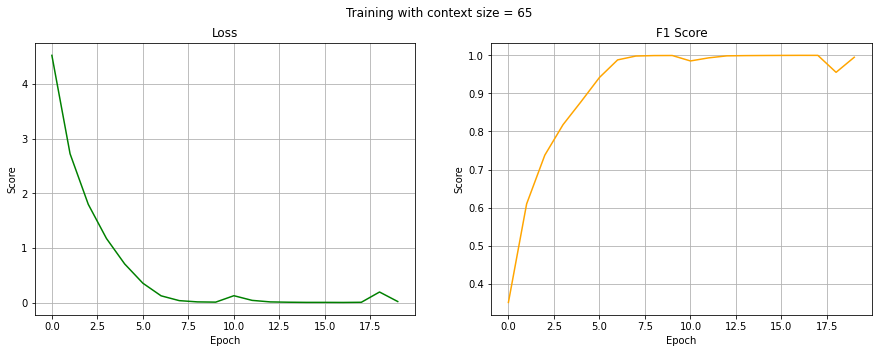

In [12]:
def looping_step(dataloader, model, optimizer, criterion, metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_losses = []
    epoch_metric_scores = []
    patience_counter = 0
    
    now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
    path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
    os.makedirs(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}")
    
    # Hyperparameters
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 50}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 50}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
        
        batch_losses, batch_metric_scores = training_step(dataloader, model, optimizer, criterion, metric, path_name=path_name)
        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))

        epoch_loss = torch.mean(torch.FloatTensor(batch_losses))
        epoch_losses.append(epoch_loss.item())

        epoch_metric_score = torch.mean(torch.FloatTensor(batch_metric_scores))
        epoch_metric_scores.append(epoch_metric_score.item())
        
        with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_losses[-1] < epoch_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")                    
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write(f"\nMean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                elif epoch_metric_scores[-1] > epoch_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_loss = (epoch_loss)
                    best_metric = (epoch_metric_score)
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"Mean {str(criterion).split('(')[0]}: {(epoch_loss):.4f} | Mean {str(metric).split('(')[0]}: {(epoch_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 50, end="\n\n")
            f.write(f"{'=' * 50}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        metric.reset()
    
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_losses, "green")
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_metric_scores, "orange")
    ax_metric_score.grid()

    plt.savefig(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    criterion_name = "Best " + str(criterion).split('(')[0]
    metric_name = "Best " + str(metric).split('(')[0]
    
    print(f"{criterion_name.ljust(18)}: {best_loss:.4f}")
    print(f"{metric_name.ljust(18)}: {best_metric:.4f}")
    print(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.")
    print(f"{'Training date'.ljust(18)}: {now}")
    
    with open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 50}\n")
        f.write(f"{criterion_name.ljust(18)}: {best_loss:.4f}\n")
        f.write(f"{metric_name.ljust(18)}: {best_metric:.4f}\n")
        f.write(f"{'Training duration'.ljust(18)}: {((finish_time - start_time) / 60):.3f} minutes.\n")
        f.write(f"{'Training date'.ljust(18)}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    filename_model_params = f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/model_params.pth"
    filename_oov_embedding_dict = open(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/oov_embedding_dict.pkl", "ab")
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_losses) + 1)),
            "loss": epoch_losses
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_losses.csv", index=False)
    
    pd.DataFrame(
        data={
            "epoch": list(range(1, len(epoch_metric_scores) + 1)),
            "f1_score": epoch_metric_scores
        }
    ).to_csv(f"../../logs/comick/{hyperparams.context_size}_contexts/{path_name}/epoch_metric_scores.csv", index=False)
    
    torch.save(best_state_dict, filename_model_params)
    pickle.dump({token : embedding for token, embedding in zip(list(labels_to_idx.keys()), model.embedding)}, filename_oov_embedding_dict)
    
    return epoch_losses, epoch_metric_scores

epoch_losses, epoch_metric_scores = looping_step(dataloader, model, optimizer, criterion, metric)

# END

In [13]:
model.embedding

array([[ 1.8923348 ,  4.542819  , -2.51839   , ...,  4.852777  ,
        -2.2821963 , -1.7584354 ],
       [ 4.6935143 , -3.779116  , -5.0280275 , ..., -1.2798173 ,
         1.7461338 ,  3.7477336 ],
       [ 2.8594537 , -3.7452493 , -8.464219  , ...,  0.20333871,
        -2.8956873 ,  5.2649093 ],
       ...,
       [ 7.3508425 ,  7.6894984 , -1.7009499 , ..., -1.3672771 ,
        -3.99291   , -3.6716337 ],
       [-3.6385963 ,  1.6200545 ,  1.4191867 , ...,  2.7713852 ,
         1.6803381 ,  2.3960505 ],
       [ 1.4085296 , -4.7929792 ,  0.70994484, ..., -7.570637  ,
        -1.1925044 ,  0.99271935]], dtype=float32)

In [14]:
model.state_dict()

OrderedDict([('bilstm_left_context_feature.weight_ih_l0',
              tensor([[ 0.0669, -0.2860,  0.1029,  ..., -0.2803,  0.3240, -0.6295],
                      [-0.1879, -0.2298,  0.0050,  ..., -0.1224,  0.5650, -0.4005],
                      [ 0.4350, -0.4043,  0.0774,  ..., -0.3503,  0.1721, -0.1651],
                      ...,
                      [ 0.3961, -0.5096, -0.2302,  ..., -0.2529,  0.2428, -0.2204],
                      [ 0.1716, -0.0670,  0.3009,  ...,  0.1891, -0.0538,  0.0121],
                      [ 0.3298,  0.0397,  0.1945,  ..., -0.4660,  0.1667,  0.0145]])),
             ('bilstm_left_context_feature.weight_hh_l0',
              tensor([[-0.0703, -0.0643,  0.1357,  ..., -0.0996, -0.1409, -0.0676],
                      [-0.0014,  0.2026,  0.0278,  ..., -0.0498, -0.1678, -0.0183],
                      [-0.1489,  0.0262, -0.0059,  ...,  0.2182, -0.1733,  0.1204],
                      ...,
                      [ 0.0086, -0.1253, -0.0009,  ..., -0.1089, -0.093